In [8]:
import os
import sys
import math
import time
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.utils
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import pycocotools.coco as COCO

In [9]:
root_path = './River-Evaluation'

sys.path.append(root_path)

from util_data import *
from model_base import *
from engine import *

## Parameter and Hyperparameter ##

In [10]:
# model training hyperparameters
num_classes = 3
num_epoch = 20
learning_rate = 4.000000000000001e-06
Gamma = 0.2
Batch_size = 4
backbone_trainable = True
Step_size = 10
resize_size = 512
model_name = 'unetresnet50_transfer_adam_512_2'
checkpoint_name = 'unetresnet50_transfer_adam_512_2'

# basic transform for input data
rand_transform = True

trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                 [0.229, 0.224, 0.225])
                           ])

#to cuda
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device', device)

device cpu


## Load Dataset and Dataloader ##

In [ ]:
# visualizing the dataset
dataset_test = river_dataset_resnetunet(root_path + '/train/', 
                                        rand_transform = rand_transform,
                                        transform = trans,
                                        num_class = num_classes,
                                        resized_size = resize_size
                                       )
dataloader_test = torch.utils.data.DataLoader(dataset_test, 
                                              batch_size = 2, 
                                              shuffle = False, 
                                              num_workers = 0)
img, target = next(iter(dataloader_test))
print(img.shape, target.shape)

In [ ]:
# Get a batch of training data
inputs, masks = next(iter(dataloader_test))
print(inputs.shape, masks.shape)

#plot the data
input_img = reverse_transform(inputs[1])
mask_img = masks_to_colorimg(masks[1])
f, (axarr1, axarr2) = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(8, 8))
axarr1.imshow(input_img, interpolation='nearest')
axarr2.imshow(mask_img, interpolation='nearest')

In [ ]:
# define dataset for training and validation
dataset = river_dataset_resnetunet(root_path + '/train/', 
                                   rand_transform = rand_transform,
                                   transform = trans,
                                   num_class = num_classes,
                                   resized_size = resize_size
                                  )

dataset_test = river_dataset_resnetunet(root_path + '/train/', 
                                   rand_transform = False,
                                   transform = trans,
                                   num_class = num_classes,
                                   resized_size = resize_size
                                  )

#randomly assign train and val dataset
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-35])
dataset_val = torch.utils.data.Subset(dataset_test, indices[-35:])

print("train dataset", len(dataset_train))
print("val dataset", len(dataset_val))

# define training and validation data loaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, 
                                               batch_size = Batch_size, 
                                               shuffle = True, 
                                               num_workers = 4)

dataloader_val = torch.utils.data.DataLoader(dataset_val, 
                                             batch_size = 1, 
                                             shuffle = False, 
                                             num_workers = 4,)

## Model ##

In [5]:
model = unetresnet50(num_classes)
model = model.to(device)

#load weight of model if available
checkpoint_path = root_path + '/'+ checkpoint_name +'.pth'

try:
    model.load_state_dict(torch.load(checkpoint_path))
    print('checkpoint loaded')
except:
    print('no checkpoint')

# set the backbone layer to be trainable or not
for l in model.base_layers:
        for param in l.parameters():
            param.requires_grad = backbone_trainable

model

no checkpoint


unetresnet50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [6]:
from torchsummary import summary
summary(model, input_size=(num_classes, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]           4,096
           Conv2d-14           [-1, 64,

## Train ##

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

# construct an optimizer (Adam)
optimizer_adam = torch.optim.Adam(params, lr = learning_rate)

In [ ]:
# construct a learning rate scheduler
lr_scheduler_adam = torch.optim.lr_scheduler.StepLR(optimizer_adam,
                                               step_size = Step_size,
                                               gamma = Gamma) 

In [ ]:
model = train_model(model, device,
                    optimizer_adam, lr_scheduler_adam,
                    dataloader_train, dataloader_val, 
                    num_epochs = num_epoch,
                    name = model_name
                   )

## Eval ##

In [29]:
dataset = river_dataset_resnetunet(root_path + '/train/', 
                                   rand_transform = False,
                                   transform = trans,
                                   num_class = num_classes,
                                   resized_size = resize_size
                                  )

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset_test = torch.utils.data.Subset(dataset, indices[141:231])

print(len(dataset_test))

dataloader_test = torch.utils.data.DataLoader(dataset_test, 
                                              batch_size = 1, 
                                              shuffle = False, 
                                              num_workers = 4,)

90


In [30]:
device = torch.device('cpu')

eval_model = unetresnet50(num_classes)

eval_checkpoint_name = 'unetresnet50_transfer_adam_512'
eval_checkpoint_path = root_path + '/'+ eval_checkpoint_name +'.pth'

eval_model.load_state_dict(torch.load(eval_checkpoint_path, map_location=torch.device('cpu')))
try:
    eval_model.eval()
    eval_model = eval_model.to(device)
    print("set to eval mode")
except:
    print("error")

set to eval mode


In [31]:
inputs, labels = next(iter(dataloader_test)) 
inputs = inputs.to(device)
labels = labels.to(device)
print('inputs shape', inputs.shape)
print('labels shape', labels.shape)

inputs shape torch.Size([1, 3, 512, 512])
labels shape torch.Size([1, 3, 512, 512])


In [32]:
pred = eval_model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print('pred shape', pred.shape)

pred shape (1, 3, 512, 512)


In [33]:
input_img = reverse_transform(inputs[0].cpu())
label_img = masks_to_colorimg(labels[0].cpu())
pred_img = masks_to_colorimg(pred[0])

Text(0.5, 1.0, 'Predicted Image')

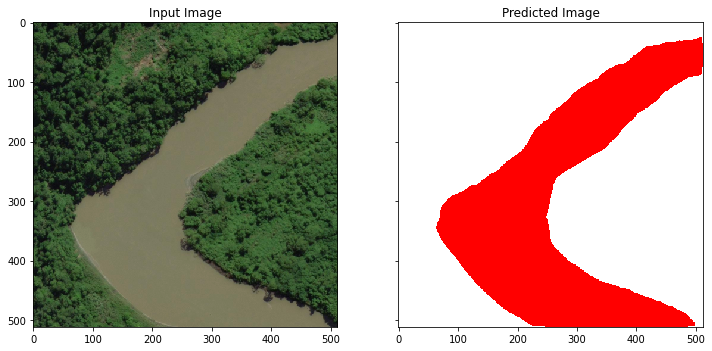

In [37]:
f, (axarr1, axarr3) = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(12, 12))
axarr1.imshow(input_img, interpolation='nearest')
axarr1.set_title('Input Image')
axarr3.imshow(pred_img, interpolation='nearest')
axarr3.set_title('Predicted Image')